<img style="float:left" width="70%" src="../../documentacion/imagenes/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="10%" src="../../documentacion/imagenes/PythonLogo.svg">
<br style="clear:both;">


<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">8. Deep Learning LSTM</h2>


 
## Estudiante:

- Jose Luis Perez Gomez

In [190]:
%run 3.Importaciones.ipynb
%run 4.Variables_Clases.ipynb

In [191]:
experimento_1_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado1.csv', sep=',')
experimento_2_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado2.csv', sep=',')
experimento_3_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado3.csv', sep=',')
experimento_4_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado4.csv', sep=',')
experimento_all_nor = pd.read_csv('../datos/experimento_stscaler_all.csv', sep=',')
experimento_all_nor_separado = pd.read_csv('../datos/experimento_stscaler_separado_all.csv', sep=',')

experimento_1_nor_separado = experimento_1_nor_separado.drop(['Timestamp'], axis=1)
experimento_2_nor_separado = experimento_2_nor_separado.drop(['Timestamp'], axis=1)
experimento_3_nor_separado = experimento_3_nor_separado.drop(['Timestamp'], axis=1)
experimento_4_nor_separado = experimento_4_nor_separado.drop(['Timestamp'], axis=1)

experimentos_nor = [experimento_1_nor_separado, experimento_2_nor_separado, experimento_3_nor_separado, experimento_4_nor_separado, experimento_all_nor, experimento_all_nor_separado ]


# LSTM (Long short-term memory)

In [192]:
train_datos, val_datos, test_datos = dividir_datos_deep(experimento_all_nor_separado)

In [193]:
print(f'train_datos: {train_datos.shape}')
print(f'val_datos: {val_datos.shape}')
print(f'test_datos: {test_datos.shape}')

train_datos: (542, 11)
val_datos: (67, 11)
test_datos: (69, 11)


In [194]:
train_datos['Key'].value_counts()

Key
0.0    149
1.0    112
4.0    102
3.0     90
2.0     89
Name: count, dtype: int64

In [195]:
val_datos['Key'].value_counts()

Key
0.0    17
3.0    14
4.0    14
1.0    13
2.0     9
Name: count, dtype: int64

In [196]:
test_datos['Key'].value_counts()

Key
0.0    20
2.0    16
1.0    15
4.0    11
3.0     7
Name: count, dtype: int64

In [206]:

def preparar_ventanas(datos, target, window_size=WINDOWS_SIZE, overlap=OVERLAP, target_type=TARGET_TYPE):
    
    if window_size <= overlap:
        raise "Overlap no puede ser mayor que window_size"
    X = []
    y = []
    for i in range(0, len(datos) - window_size, window_size - overlap):
        X.append(datos[i:i+window_size])
        window_targets = target[i:i+window_size].astype(int)
        y_true = window_targets[-1]
        y.append(y_true)

    y_one_hot = tf.keras.utils.to_categorical(np.array(y), num_classes = 5)
    # Key = [0, 1, 2, 3, 4, 0]
    # One-hot [
    #    [0, 1, 2, 3, 4]
    #     1  0  0  0  0
    #     0  1  0  0  0
    #     0  0  1  0  0
    #]
    return np.array(X), y_one_hot
    #return np.array(X), np.array(y)

In [207]:
columns = train_datos.columns[train_datos.columns != TARGET]



In [208]:
X_train, y_train = preparar_ventanas(train_datos[columns].values, train_datos[TARGET].values, WINDOWS_SIZE, OVERLAP, TARGET_TYPE)
X_val, y_val = preparar_ventanas(val_datos[columns].values, val_datos[TARGET].values, WINDOWS_SIZE, OVERLAP, TARGET_TYPE)
X_test, y_test = preparar_ventanas(test_datos[columns].values, test_datos[TARGET].values, WINDOWS_SIZE, OVERLAP, TARGET_TYPE)

In [209]:
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test: {y_test.shape}')


X_train: (539, 3, 10)
X_val: (64, 3, 10)
X_test: (66, 3, 10)
y_train: (539, 5)
y_val: (64, 5)
y_test: (66, 5)


In [233]:
# Definición del modelo
timesteps = 30
features = 10

def crear_LSTM(input_size, num_classes):
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(units=128, input_shape=input_size))
    model_LSTM.add(Dense(num_classes, activation='softmax'))
                        
    return model_LSTM




In [234]:
num_classes = 5
#input_size = X_train.shape[1:]
input_size1 = X_train.shape
print(input_size)
print(input_size1)
model_LSTM = crear_LSTM(input_size1, num_classes)
model_LSTM.summary()


(3, 10)
(539, 3, 10)


C:\Users\Casa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 539, 3, 10)

In [224]:
checkpoint_filepath = 'checkpoint/mlp.keras'

# Crear checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# Hiperparámetros
batch_size = 32
learning_rate = 1e-4
epochs = 50
dropout = 0.5
weight_decay = 1e1



# Compilamos el modelo
optimizador = Adam(learning_rate=learning_rate)
#optimizador = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
model_LSTM.compile(optimizer= optimizador,
                  loss='categorical_crossentropy',
                  metrics=["accuracy", tf.keras.metrics.F1Score("weighted")])

# Entrenar
LSTM_output = model_LSTM.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs, batch_size=batch_size,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1939 - f1_score: 0.1804 - loss: 1.6115 - val_accuracy: 0.0625 - val_f1_score: 0.0606 - val_loss: 1.6195
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1905 - f1_score: 0.1868 - loss: 1.6113 - val_accuracy: 0.1094 - val_f1_score: 0.1239 - val_loss: 1.6187
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2231 - f1_score: 0.2273 - loss: 1.5973 - val_accuracy: 0.1250 - val_f1_score: 0.1389 - val_loss: 1.6176
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2805 - f1_score: 0.2813 - loss: 1.5915 - val_accuracy: 0.1406 - val_f1_score: 0.1452 - val_loss: 1.6175
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2902 - f1_score: 0.2840 - loss: 1.5885 - val_accuracy: 0.1406 - val_f1_score: 0.1400 - val_loss: 1.6166
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3119 - f1_score: 0.2998 - loss: 1.5792 - val_accuracy: 0.1406 - val_f1_score: 0.1514 - val_loss

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3636 - f1_score: 0.3356 - loss: 1.4608 - val_accuracy: 0.2188 - val_f1_score: 0.2293 - val_loss: 1.5775
Epoch 42/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3430 - f1_score: 0.3106 - loss: 1.5018 - val_accuracy: 0.2188 - val_f1_score: 0.2293 - val_loss: 1.5763
Epoch 43/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3656 - f1_score: 0.3456 - loss: 1.4788 - val_accuracy: 0.2344 - val_f1_score: 0.2465 - val_loss: 1.5750
Epoch 44/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3412 - f1_score: 0.3066 - loss: 1.4738 - val_accuracy: 0.2188 - val_f1_score: 0.2330 - val_loss: 1.5741
Epoch 45/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3502 - f1_score: 0.3212 - loss: 1.4998 - val_accuracy: 0.2188 - val_f1_score: 0.2330 - val_loss: 1.5734
Epoch 46/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4026 - f1_score: 0.3734 - loss: 1.4467 - val_accuracy: 0.2188 - val_f1_score: 0.2330 - val_loss: 1.572

In [225]:
def learning_curve(history, key='loss', title='Loss curve'):
    epochs = np.arange(1, len(history.history[key]) + 1)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history[key], label='Training')
    plt.plot(epochs, history.history['val_' + key], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.legend()

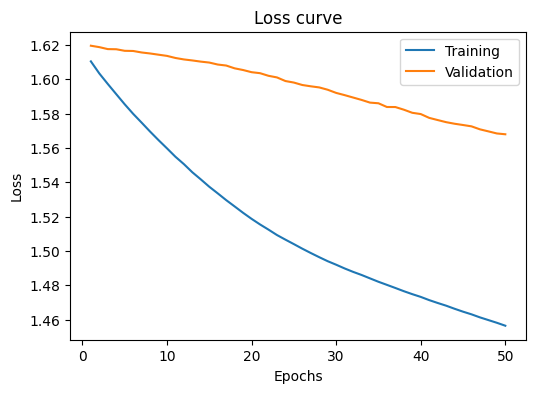

In [226]:
learning_curve(LSTM_output, 'loss')

In [227]:
# Cargar pesos del mejor modelo
model_LSTM.load_weights(checkpoint_filepath)

In [228]:
probabilidades_val = model_LSTM.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


In [229]:
y_val_pred = probabilidades_val.argmax(1)
print(y_val_pred)
etiquetas_val = y_val.argmax(1)
print(etiquetas_val)

[2 4 3 3 3 3 3 3 3 3 1 3 3 3 3 3 4 4 4 4 4 4 4 4 4 1 3 3 3 1 1 1 3 1 1 3 3
 0 0 0 4 4 4 2 0 0 0 4 0 1 1 3 3 3 4 4 2 2 2 2 1 2 2 2]
[2 2 2 2 2 2 2 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0]


In [230]:
print(classification_report(etiquetas_val, y_val_pred, target_names=CLASES_KEY))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35        16
           1       0.30      0.23      0.26        13
           2       0.11      0.14      0.12         7
           3       0.18      0.29      0.22        14
           4       0.12      0.14      0.13        14

    accuracy                           0.22        64
   macro avg       0.26      0.21      0.22        64
weighted avg       0.28      0.22      0.23        64



In [231]:
def visualizar_matriz_confusion(etiquetas_reales, etiquetas_predichas, class_names, titulo):
    # Calcular matriz de confusión
    cm = confusion_matrix(etiquetas_reales, etiquetas_predichas)

    # Visualizar matriz de confusión
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(titulo)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

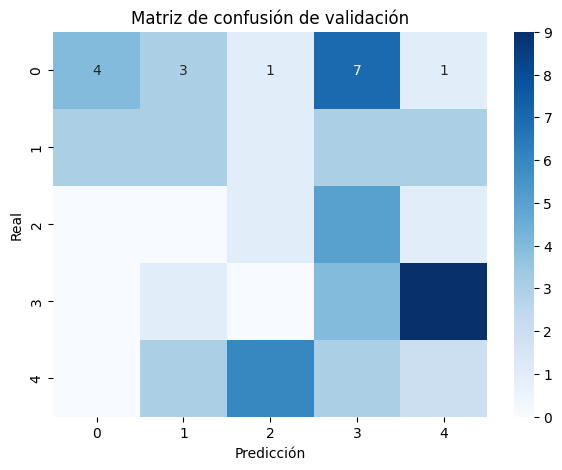

In [232]:
visualizar_matriz_confusion(etiquetas_val, y_val_pred, CLASES_KEY, 'Matriz de confusión de validación')